# Preprocessing P3128 with Scanpy

This notebook is devoted to preprocessing the gene data from experiment P3128.  We load the metadata, expression matrices, and we load gene metadata (from the BioMart).  We put all this together into three Scanpy AnnData objects, and save them as loom files.

# Loading packages

In [1]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

import scipy.stats as ss
from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
file_prefix = 'Processed/'
file_suffix = '.loom'

In [3]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Loading data

## Getting gene data

Gene data was downloaded [GRCh7 at the biomart](https://grch37.ensembl.org/info/data/biomart/index.html), and we work at the level of distinct Ensembl IDs.  Transcript length (used for TPM normalization) is obtained by averaging all entries with a given Ensembl ID.

In [4]:
def get_genes(filename, verbose=True):
    gene_raw = pd.read_csv(filename, sep='\t', index_col=0, header=0, low_memory=False)
    #gene_raw.columns = ['transcript_length', 'gene_name', 'GC_content','transcript stable ID', 'TSS']
    if verbose:
        print('{} genes found in {}.'.format(len(gene_raw), filename))
    
    gene_lengths = gene_raw['Transcript length (including UTRs and CDS)'].groupby(gene_raw.index).mean()
    gene_GCs = gene_raw['Gene % GC content'].groupby(gene_raw.index).mean()
    gene_df = pd.DataFrame(gene_lengths, index=gene_lengths.index)
    gene_df.columns = ['transcript_length']
    gene_df['GC_content'] = gene_GCs
    gene_df['gene_name'] = gene_raw['Gene name'].groupby(gene_raw.index).first()
    #gene_df['chrome'] = gene_raw['Chromosome/scaffold name'].groupby(gene_raw.index).first()
    #gene_df['GO_term'] = gene_raw['GO term name'].groupby(gene_raw.index).first()
    if verbose:
        print('{} distinct Ensembl gene IDs found.'.format(len(gene_df)))
        display(gene_df.head())
    return gene_df

In [5]:
gene_df = get_genes('Raw/GRCh37_Biomart.txt')

215404 genes found in Raw/GRCh37_Biomart.txt.
63677 distinct Ensembl gene IDs found.


,transcript_length,GC_content,gene_name
Gene stable ID,,,
ENSG00000000003,1350.333333,40.87,TSPAN6
ENSG00000000005,940.500000,40.80,TNMD
ENSG00000000419,974.714286,39.85,DPM1
ENSG00000000457,3274.400000,40.14,SCYL3
ENSG00000000460,2197.200000,39.22,C1orf112


## Getting cell metadata

In [6]:
def get_meta(experiment, filename = '', report=True, invitro = True, invivo = False, bulks = False):
    df = pd.read_csv(filename, sep=',', index_col=1, header=0, low_memory=False)
    df = df.loc[df['Sample_ID'].notnull()] # Only keep cells with sample ID.
    print('Discarding samples without Sample ID.  {} samples remaining.'.format(len(df)))
    df['Project_ID'] = [sid[:5] for sid in df.index] 
    df = df[ df['Project_ID'] == experiment] # Only cells from the experiment.
    print('{} samples found in experiment {}.'.format(len(df), experiment))
    
    df = df.loc[df['Clone_ID'].notnull()] # Only keep cells with Clone ID.
    print('Discarding samples without Clone ID.  {} samples remaining.'.format(len(df)))
    if invitro:
        df = df.loc[df['Condition'] == 'In_Vitro'] 
        print('Discarding samples that are not in-vitro.  {} samples remaining'.format(len(df)))
    elif invivo:
        df = df.loc[df['Condition'] == 'In_Vivo'] 
        print('Discarding samples that are not in-vivo.  {} samples remaining'.format(len(df)))
    df.drop('Sample_ID', axis=1, inplace=True)
    df.index = [cn[:-1] for cn in df.index]
    if bulks:
        df = df[ df['Cell_Number'] > 1] # Include only bulks.
        print('Discarding single cells.  {} bulks remaining'.format(len(df)))
    else:
        df = df[ df['Cell_Number'] == 1] # Get rid of bulks.
        print('Discarding bulks.  {} single cells remaining'.format(len(df)))
    if report:
        if bulks:
            print('{} bulks found in experiment {}'.format(len(df), experiment))
        else:
            print('{} single cells found in experiment {}'.format(len(df), experiment))
        clones = df['Clone_ID'].unique()
        print('{} Clones: {}'.format(len(clones), ', '.join(clones)))
        print('The first five rows of the dataframe are below')
        display(df[:5])
    return df

In [7]:
meta_sc = get_meta('P3128', filename = 'Raw/metadata_marty_NFCORE_Sept2019.csv')
cells = list(meta_sc.index)

Discarding samples without Sample ID.  2345 samples remaining.
563 samples found in experiment P3128.
Discarding samples without Clone ID.  560 samples remaining.
Discarding samples that are not in-vitro.  372 samples remaining
Discarding bulks.  334 single cells remaining
334 single cells found in experiment P3128
24 Clones: D2, H3, D6, F7, A2, B6, C6, E7, B12, C2, H6, F11, B4, E8, D1, A7, D10, F6, A8, G3, F4, E2, B10, H4
The first five rows of the dataframe are below


,Condition,Cell_Number,Clone_ID,Day,In_Vivo_Clone_ID,Project_ID
P3128_1193,In_Vitro,1.0,D2,NaN,3.0,P3128
P3128_1194,In_Vitro,1.0,D2,NaN,3.0,P3128
P3128_1195,In_Vitro,1.0,D2,NaN,3.0,P3128
P3128_1196,In_Vitro,1.0,D2,NaN,3.0,P3128
P3128_1197,In_Vitro,1.0,D2,NaN,3.0,P3128


In [8]:
meta_bulks = get_meta('P3128', filename = 'Raw/metadata_marty_NFCORE_Sept2019.csv', bulks=True)
bulks = list(meta_bulks.index)

Discarding samples without Sample ID.  2345 samples remaining.
563 samples found in experiment P3128.
Discarding samples without Clone ID.  560 samples remaining.
Discarding samples that are not in-vitro.  372 samples remaining
Discarding single cells.  38 bulks remaining
38 bulks found in experiment P3128
19 Clones: D2 BULK, H3 BULK, D6 BULK, F7 BULK, A2 BULK, B6 BULK, C6 BULK, E7 BULK, B12 BULK, C2 BULK, H6 BULK, F11 BULK, B4 BULK, E8 BULK, D1 BULK, A7 BULK, A8 BULK, E2 BULK, H4 BULK
The first five rows of the dataframe are below


,Condition,Cell_Number,Clone_ID,Day,In_Vivo_Clone_ID,Project_ID
P3128_1200,In_Vitro,20.0,D2 BULK,NaN,3.0,P3128
P3128_1208,In_Vitro,20.0,D2 BULK,NaN,3.0,P3128
P3128_1216,In_Vitro,20.0,H3 BULK,NaN,11.0,P3128
P3128_1224,In_Vitro,20.0,H3 BULK,NaN,11.0,P3128
P3128_1232,In_Vitro,20.0,D6 BULK,NaN,55.0,P3128


In [9]:
meta_bulks['Cell_Number'].value_counts()

20.0    24
10.0     7
5.0      6
4.0      1
Name: Cell_Number, dtype: int64

The bulks vary in size, from 4 cells up to 20 cells.

## Getting expression matrices

In [10]:
def get_counts(filename, gdf):
    df = pd.read_csv(filename, sep='\t',
                     index_col=0, header=0, low_memory=False)
    df = df[df.columns[1:]]
    cols = list(df.columns)
    cols = ['_'.join(col.split('_')[3:5]) for col in cols]
    df.columns = cols
    return df

In [11]:
foldername = 'Raw/NFCore_Joanna_Mapped_Sept2019/'
counts_all = get_counts(foldername+'P3128_merged_gene_counts.tsv', gene_df)
counts_sc = counts_all[cells]
counts_sc.head()

,P3128_1193,P3128_1194,P3128_1195,P3128_1196,P3128_1197,P3128_1198,P3128_1199,P3128_1201,P3128_1202,P3128_1203,...,P3128_1565,P3128_1566,P3128_1567,P3128_1569,P3128_1570,P3128_1571,P3128_1572,P3128_1573,P3128_1574,P3128_1575
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,6,2,0,0,0,3,0,2,2,0,...,11,34,94,45,18,15,8,0,19,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
counts_bulks = counts_all[bulks]
counts_bulks.head()

,P3128_1200,P3128_1208,P3128_1216,P3128_1224,P3128_1232,P3128_1240,P3128_1248,P3128_1256,P3128_1264,P3128_1272,...,P3128_1424,P3128_1432,P3128_1440,P3128_1448,P3128_1488,P3128_1496,P3128_1536,P3128_1544,P3128_1568,P3128_1576
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,4,5,60,59,46,43,9,7,10,38,...,14,92,30,5,3,8,1,10,39,77
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Moving into Scanpy

In [13]:
def moveto_scanpy(counts, cell_meta, gene_meta, plain_name = True):
    adata = sc.AnnData(counts.T)
    for gene_property in gene_meta.columns:
        adata.var[gene_property] = gene_meta[gene_property]
    for cell_property in cell_meta.columns:
        adata.obs[cell_property] = cell_meta[cell_property]
    if plain_name:
        adata.var.index = adata.var['gene_name'] # Reindex by gene name
        adata.var_names_make_unique() # Use common gene names, but uniquify them.
    
    return adata

In [14]:
adata = {}
adata['sc'] = moveto_scanpy(counts_sc, meta_sc, gene_df)
adata['bulks'] = moveto_scanpy(counts_bulks, meta_bulks, gene_df)

datasets = ['sc','bulks']

/opt/anaconda3/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD113-1', 'SNORD113-2']
  warnings.warn(


#  Filtering and normalization

We first filter out genes which are never expressed above a count of 10, and those which are expressed in less than 5% of cells.

In [15]:
for ds in datasets:
    genes_before = adata[ds].n_vars
    sc.pp.filter_genes(adata[ds], min_counts=10) # At least 10 count.
    sc.pp.filter_genes(adata[ds], min_cells=0.05*adata[ds].n_obs) # At least 5% of cells.
    genes_after = adata[ds].n_vars
    print('Dataset {} has {} genes before and {} genes after filtering.'.format(ds,genes_before,genes_after))

Dataset sc has 63677 genes before and 10500 genes after filtering.
Dataset bulks has 63677 genes before and 15181 genes after filtering.


We use the Seuratv3 flavor of selection for highly variable genes, which uses unnormalized data.  See [Scanpy documentation](https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.highly_variable_genes.html#scanpy.pp.highly_variable_genes) for more.

In [16]:
for ds in datasets:
    print('Identifying highly variable genes in {}'.format(ds))
    sc.pp.highly_variable_genes(adata[ds], n_top_genes=7500, flavor='seurat_v3')
    #sc.pl.highly_variable_genes(adata[ds], log=True)

Identifying highly variable genes in sc
Identifying highly variable genes in bulks


/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Now we carry out TPM normalization.

In [17]:
def TPM_norm(ad, target_sum=1e6):
    ad_out = ad.copy()
    
    df = ad_out.to_df().T
    
    # Step 1:  divide each entry by the transcript length of the gene, in kilobases.
    rdf = 1 / ad_out.var['transcript_length']
    df = df.mul(1000*rdf,axis=0) # Multiply by 1000 to convert transcript length to kilobases.
    
    # Transpose for what follows.
    df = df.T
    
    # Step 2:  divide each entry by cell-total, then multiply by target_sum.
    rdf = 1/df.sum(axis=1)
    df = df.mul(rdf, axis=0)
    df = df * target_sum 
    
    # Double-check TPM normalization has succeeded.
    print('The TPM normalization has failed for {} samples.'.format(((df.sum(axis=1) - target_sum) > 0.1).sum()))
    
    # Return new dataframe.
    ad_out.X = df
    return ad_out

In [18]:
for ds in datasets:
    adata[ds] = TPM_norm(adata[ds]) # TPM normalize.

The TPM normalization has failed for 0 samples.
The TPM normalization has failed for 0 samples.


Pseudo-log normalization is next.

In [19]:
for ds in datasets:
    sc.pp.log1p(adata[ds]) #pseudo-log normalize.

In [20]:
for ds in datasets:
    print('Summary of AnnData object for {} (shape = #samples x #genes)'.format(ds))
    print(adata[ds])
    hrule()

Summary of AnnData object for sc (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 334 × 10500
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID'
    var: 'transcript_length', 'GC_content', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
Summary of AnnData object for bulks (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 38 × 15181
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID'
    var: 'transcript_length', 'GC_content', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'


## Dropping T-cell Receptor Genes

We drop all genes that begin with TRA, TRB, TRG, TRJ.

In [21]:
def drop_TRs(ad, prefixes = ['TRA','TRB', 'TRD', 'TRG','TRJ']):
    ad_out = ad
    for prefix in prefixes:
        bad_genes = [gene for gene in ad_out.var_names if gene.startswith(prefix)]
        print('{} genes starting with {} are removed.'.format(len(bad_genes),prefix))
        keep_genes = [gene for gene in ad_out.var_names if not gene.startswith(prefix)]
        ad_out = ad_out[:, keep_genes]
    return ad_out

In [22]:
for ds in datasets:
    before_genes = len(adata[ds].var_names)
    adata[ds] = drop_TRs(adata[ds])
    after_genes = len(adata[ds].var_names)
    print('{} T-cell receptor genes removed from adata[{}]'.format(before_genes - after_genes, ds))
    hrule()

73 genes starting with TRA are removed.
26 genes starting with TRB are removed.
1 genes starting with TRD are removed.
11 genes starting with TRG are removed.
0 genes starting with TRJ are removed.
111 T-cell receptor genes removed from adata[sc]
103 genes starting with TRA are removed.
31 genes starting with TRB are removed.
2 genes starting with TRD are removed.
16 genes starting with TRG are removed.
0 genes starting with TRJ are removed.
152 T-cell receptor genes removed from adata[bulks]


# Quality control

We check on the highest expressed genes (before normalization)

/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


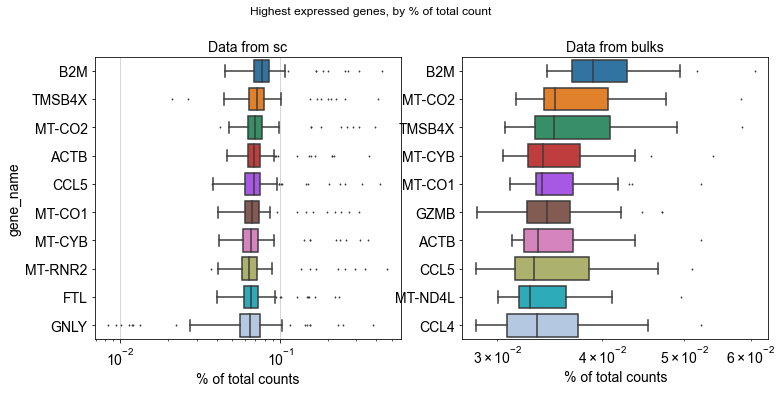

In [23]:
fig,ax = plt.subplots(1,len(datasets), figsize=(len(datasets)*6,5))
for j,ds in enumerate(datasets):
    sc.pl.highest_expr_genes(adata[ds], n_top=10, ax=ax[j], log=True, show=False)
    ax[j].set_title('Data from {}'.format(ds))
    if j > 0:
        ax[j].set_ylabel('')
plt.suptitle('Highest expressed genes, by % of total count', y=1.05)
plt.show()

We look at MT-genes for quality control too.

In [24]:
for ds in datasets:
    adata[ds].var['mt'] = adata[ds].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata[ds], qc_vars=['mt'], percent_top=None, inplace=True)

Here we look at total counts and number of genes, to filter out "bad cells".

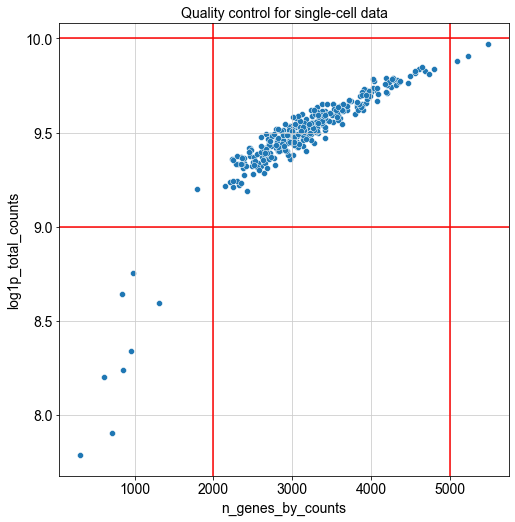

In [25]:
fig,ax = plt.subplots(1,1, figsize=(8,8))

sns.scatterplot(x='n_genes_by_counts', y='log1p_total_counts', 
                data=adata['sc'].obs,  ax=ax)
ax.set_title('Quality control for single-cell data')

# Choose these after examining the plot!
min_logcounts = 9 
max_logcounts = 10.0 
min_genes = 2000
max_genes = 5000
ax.axhline(min_logcounts, color='red')
ax.axhline(max_logcounts, color='red')
ax.axvline(min_genes, color='red')
ax.axvline(max_genes, color='red')
plt.show()

Now we filter, and double-check that we've kept only the cells in the desired window.

In [26]:
sc.pp.filter_cells(adata['sc'], min_genes=min_genes)
sc.pp.filter_cells(adata['sc'], max_genes=max_genes)

adata['sc'] = adata['sc'][adata['sc'].obs.log1p_total_counts > min_logcounts, :]
adata['sc'] = adata['sc'][adata['sc'].obs.log1p_total_counts < max_logcounts, :]

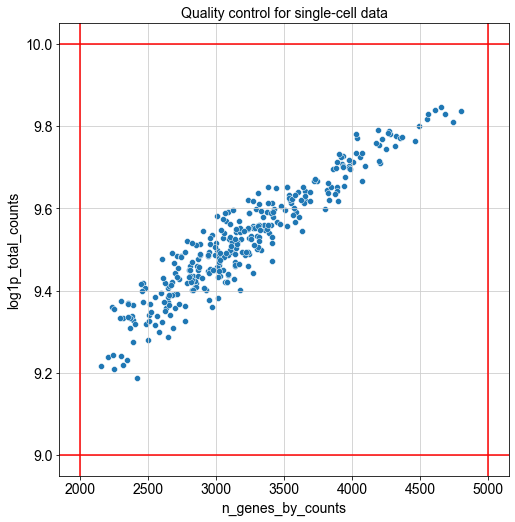

In [27]:
fig,ax = plt.subplots(1,1, figsize=(8,8))


sns.scatterplot(x='n_genes_by_counts', y='log1p_total_counts', 
                data=adata['sc'].obs,  ax=ax)
ax.set_title('Quality control for single-cell data')

# Choose these after examining the plot!
min_logcounts = 9 
max_logcounts = 10
min_genes = 2000
max_genes = 5000
ax.axhline(min_logcounts, color='red')
ax.axhline(max_logcounts, color='red')
ax.axvline(min_genes, color='red')
ax.axvline(max_genes, color='red')
plt.show()

In [28]:
cells = adata['sc'].obs.index
bulks = adata['bulks'].obs.index

In [29]:
for ds in datasets:
    print(adata[ds])
    hrule()

View of AnnData object with n_obs × n_vars = 322 × 10389
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'transcript_length', 'GC_content', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p'
AnnData object with n_obs × n_vars = 38 × 15029
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'transcript_length', 'GC_content', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', '

# Add clonal information

In [30]:
clone_df = pd.read_csv('Raw/Marty_Clones_P3128_Meta.csv', sep=',', header=0, index_col=0)
clone_df = clone_df[['Clone ID', 'Clone_Number_In-Vitro']]
clone_df = clone_df.loc[cells]
clone_df.columns = ['Well_ID', 'Clone_ID']
clone_df.Clone_ID = clone_df.Clone_ID.astype(str).apply(lambda x : x[:-2])
clone_df.head()

,Well_ID,Clone_ID
P3128_1193,D2,3
P3128_1194,D2,3
P3128_1195,D2,3
P3128_1197,D2,3
P3128_1198,D2,3


In [31]:
adata['sc'].obs['Clone_ID'] = clone_df['Clone_ID']
adata['sc'].obs['Well_ID'] = clone_df['Well_ID']
adata['sc'].obs

Trying to set attribute `.obs` of view, copying.


,Condition,Cell_Number,Clone_ID,Day,In_Vivo_Clone_ID,Project_ID,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,Well_ID
P3128_1193,In_Vitro,1.0,3,NaN,3.0,P3128,3927,8.275886,16463.941406,9.708988,161.169556,5.088643,0.978925,3927,D2
P3128_1194,In_Vitro,1.0,3,NaN,3.0,P3128,2252,7.720018,9998.287109,9.210269,154.109711,5.044133,1.541361,2252,D2
P3128_1195,In_Vitro,1.0,3,NaN,3.0,P3128,4202,8.343554,16472.414062,9.709503,150.002670,5.017298,0.910630,4202,D2
P3128_1197,In_Vitro,1.0,3,NaN,3.0,P3128,3361,8.120291,14021.460938,9.548416,135.238708,4.914409,0.964512,3361,D2
P3128_1198,In_Vitro,1.0,3,NaN,3.0,P3128,4058,8.308692,16749.998047,9.726213,159.790634,5.080103,0.953974,4058,D2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P3128_1567,In_Vitro,1.0,11,NaN,11.0,P3128,3085,8.034631,12582.130859,9.440112,179.751663,5.197124,1.428627,3085,H4
P3128_1570,In_Vitro,1.0,11,NaN,11.0,P3128,4493,8.410498,18049.923828,9.800952,174.670135,5.168608,0.967706,4493,H4
P3128_1571,In_Vitro,1.0,11,NaN,11.0,P3128,3936,8.278174,16326.564453,9.700610,161.588852,5.091225,0.989730,3936,H4
P3128_1572,In_Vitro,1.0,11,NaN,11.0,P3128,3415,8.136226,14624.102539,9.590495,178.423050,5.189746,1.220062,3415,H4


# Gene metrics

Here we annotate each gene with metrics which will be used later.  

## Highly variable genes
The first is a ranking for highly variable genes.  Before normalization, we used Scanpy's [highly variable genes](https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.highly_variable_genes.html) function, which annotates the highly variable genes using the methods of Seurat v3. Here we examine the 10 most variable genes.

In [32]:
adata['sc'].var.highly_variable_rank.sort_values()[:10]

gene_name
STMN1        5.0
TUBB         6.0
CSF2         7.0
HIST1H4C    10.0
CCL3        11.0
TUBA1B      12.0
RRM2        14.0
HMGB2       16.0
EGR1        17.0
UBE2C       19.0
Name: highly_variable_rank, dtype: float32

## Always on genes

Some genes are "always on" -- almost every cell expressed the gene above some minimum threshold.  We add a statistic for the percentage of cells in which the gene is expressed above a threshold of 10 (TPM-normalized count).

In [33]:
def on_ratio(ad, threshold=10):
    ad_out = ad.copy()
    EM = ad_out.to_df() 
    ad_out.var['on_ratio'] = (EM > np.log1p(10)).sum() / len(EM)
    return ad_out

In [34]:
for ds in datasets:
    adata[ds] = on_ratio(adata[ds])

## Clonality statistics

We annotate genes based on statistics for clonality:  ANOVA F, Kruskal-Wallis, and chi^2 (after binarization).

In [35]:
def group_stats(ad, groupby='Clone_ID'):
    X = ad.to_df()
    y = ad.obs[groupby]
    F_pvals = ss.f_oneway(*[X[y == k] for k in np.unique(y)])[1]
    print('ANOVA F complete.  Kruskal-Wallis may take a minute now.')
    K_pvals = X.apply(lambda col : ss.kruskal(*[col[y == k] for k in np.unique(y)])[1])
    chi2_pvals = chi2(X > np.log1p(10),y)[1]
    ad_out = ad.copy()
    ad_out.var['F_pval'] = F_pvals
    ad_out.var['K_pval'] = K_pvals
    ad_out.var['chi2_pval'] = chi2_pvals
    return ad_out

In [36]:
for ds in ['sc']:
    adata[ds] = group_stats(adata[ds])

ANOVA F complete.  Kruskal-Wallis may take a minute now.


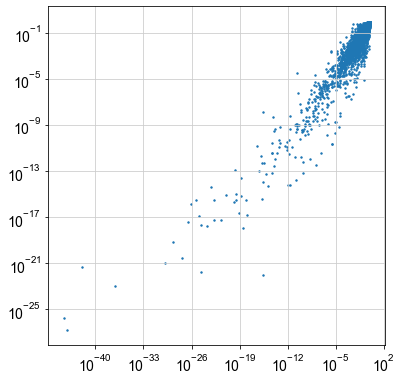

In [37]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
plt.scatter(adata['sc'].var.F_pval, adata['sc'].var.K_pval, s=2)
ax.set_xscale('log')
ax.set_yscale('log')

## Pathway annotation

We annotate some genes based on a custom list of gene pathways.

In [38]:
pathway_df = pd.read_csv('Raw/Pathway_List_Feb182020_JEMcurated.csv')
pathways = list(pathway_df.columns)
print('Adding annotation for the following pathways: {}'.format(', '.join(pathways)))

Adding annotation for the following pathways: CD3/TCR Signaling, Cytotoxicity, Exhaustion, IL-2R Signaling, Ribosomal Processes, MT-genes, Mitochondrial Respiration, Interferon Signaling


In [39]:
def add_paths(ad):
    ad_out = ad.copy()
    ad_out.var['pathway'] = ''
    for pathway in pathways:
        pathgenes = pathway_df[pathway].dropna().values
        for gene in pathgenes:
            if gene in ad_out.var_names:
                ad_out.var.loc[gene,'pathway'] = pathway
    return ad_out

In [40]:
for ds in datasets:
    adata[ds] = add_paths(adata[ds])

# Summary and saving AnnData objects

In [41]:
for ds in datasets:
    print('Summary of {} data'.format(ds))
    print(adata[ds])
    hrule()

Summary of sc data
AnnData object with n_obs × n_vars = 322 × 10389
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'Well_ID'
    var: 'transcript_length', 'GC_content', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'on_ratio', 'F_pval', 'K_pval', 'chi2_pval', 'pathway'
    uns: 'hvg', 'log1p'
Summary of bulks data
AnnData object with n_obs × n_vars = 38 × 15029
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'


In [42]:
for ds in datasets:
    filename = file_prefix+'P3128_'+ds+file_suffix
    adata[ds].write_loom(filename)
    print('Data written to {}'.format(filename))

Data written to Processed/P3128_sc.loom
Data written to Processed/P3128_bulks.loom


# Loading protein data
Now we load the protein data.  We give a list of "default" proteins to look for here.

In [43]:
proteins_default = ['CD57', 'FAS', 'PTPRC-CD45RA', 'CD4', 'IL7RA','Dextramer', 
                    'CD3E', 'CD8A', 'CCR7', 'ITGA6-CD49F', 'PDCD1', 'CD27']

In [44]:
def get_proteins(filename, cell_list, proteins = proteins_default):
    df = pd.read_csv(filename, sep=',',
                      index_col=0, header=0, low_memory=False)
    df = df.reindex(cell_list)
    proteins_occurring = [p for p in proteins if p in df.columns]
    df = df[proteins_occurring]
    df = df.apply(pd.to_numeric, errors='coerce')
    print('Average protein measurement for {} samples and {} proteins.'.format(len(df), len(df.columns)))
    display(df.mean(axis=0))
    return df

In [45]:
protein_df = get_proteins('Raw/P3128_protein.csv', cells)
protein_df.head()

Average protein measurement for 322 samples and 7 proteins.


CD57              610.814935
FAS             12187.792208
PTPRC-CD45RA      310.610390
CD3E              638.831169
CD8A            16541.090909
PDCD1            2692.172078
CD27              644.149351
dtype: float64

,CD57,FAS,PTPRC-CD45RA,CD3E,CD8A,PDCD1,CD27
P3128_1193,0.0,17391.0,623.0,661.0,15652.0,5759.0,628.0
P3128_1194,35.0,9330.0,194.0,385.0,3221.0,1542.0,1765.0
P3128_1195,7.0,14108.0,67.0,-4516.0,18247.0,110356.0,340.0
P3128_1197,50.0,7071.0,89.0,744.0,32079.0,3708.0,1289.0
P3128_1198,40.0,6554.0,93.0,464.0,21720.0,3971.0,621.0


In [46]:
protein_bulks = get_proteins('Raw/P1902_protein.csv', bulks)
protein_bulks.head()

Average protein measurement for 38 samples and 12 proteins.


CD57           NaN
FAS            NaN
PTPRC-CD45RA   NaN
CD4            NaN
IL7RA          NaN
Dextramer      NaN
CD3E           NaN
CD8A           NaN
CCR7           NaN
ITGA6-CD49F    NaN
PDCD1          NaN
CD27           NaN
dtype: float64

,CD57,FAS,PTPRC-CD45RA,CD4,IL7RA,Dextramer,CD3E,CD8A,CCR7,ITGA6-CD49F,PDCD1,CD27
P3128_1200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P3128_1208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P3128_1216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P3128_1224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P3128_1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pickling

We pickle all of our loaded data frames, just in case.

In [47]:
experiment = 'P3128'
protein_df.to_pickle('Processed/'+experiment+'_protein.pkl') # Pickled proteins.  Mmmmm...
protein_bulks.to_pickle('Processed/'+experiment+'_protein_bulks.pkl') # Pickled proteins.  Mmmmm...